# <a id='toc1_'></a>[Assignment Module 2: Product Classification](#toc0_)

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## <a id='toc1_1_'></a>[Preliminaries: the dataset](#toc0_)

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## <a id='toc1_2_'></a>[Part 1: design your own network](#toc0_)

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## <a id='toc1_3_'></a>[Part 2: fine-tune an existing network](#toc0_)

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

---
---

**Table of contents**<a id='toc0_'></a>    
- [Assignment Module 2: Product Classification](#toc1_)    
  - [Preliminaries: the dataset](#toc1_1_)    
  - [Part 1: design your own network](#toc1_2_)    
  - [Part 2: fine-tune an existing network](#toc1_3_)    
  - [Data exploration](#toc1_4_)    
    - [Train and validation distributions](#toc1_4_1_)    
  - [Data preprocessing](#toc1_5_)    
    - [Dataset loading](#toc1_5_1_)    
    - [Augmentation](#toc1_5_2_)    
    - [Rebalancing](#toc1_5_3_)    
  - [Utility functions](#toc1_6_)    
    - [Parameters count](#toc1_6_1_)    
    - [Evaluation on dataset split](#toc1_6_2_)    
    - [Training loop](#toc1_6_3_)    
    - [Plots](#toc1_6_4_)    
    - [Reporting](#toc1_6_5_)    
  - [Part 1](#toc1_7_)    
    - [Basic Model](#toc1_7_1_)    
    - [First Model](#toc1_7_2_)    
    - [Ablation study](#toc1_7_3_)    
      - [Models definition](#toc1_7_3_1_)    
      - [Tests execution](#toc1_7_3_2_)    
      - [Results](#toc1_7_3_3_)    
    - [Experiment on balanced dataset](#toc1_7_4_)    
  - [Part 2](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
!pip install torchsummary

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from pathlib import Path
from torchvision import transforms as T
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
import os
import json
from torchsummary import summary
import pandas as pd
import copy
from torchvision.models import resnet18, ResNet18_Weights


SEED = 42

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

def fix_random(seed: int) -> None:
    """
        Fix all the possible sources of randomness.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Device: cuda


## <a id='toc1_4_'></a>[Data exploration](#toc0_)

### <a id='toc1_4_1_'></a>[Train and validation distributions](#toc0_)

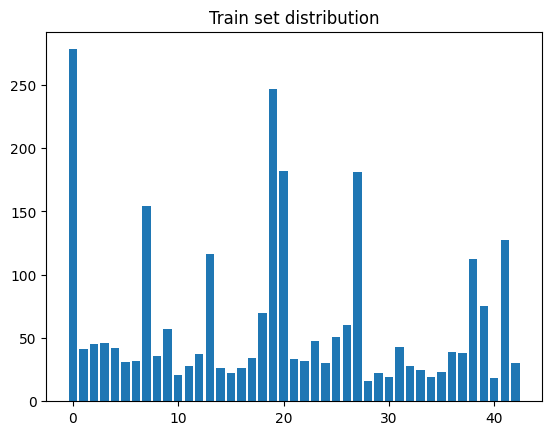

In [5]:
train_data = GroceryStoreDataset(split="train")
unique_train_classes, per_train_class_count = np.unique(train_data.labels, return_counts=True)
plt.title("Train set distribution")
plt.bar(unique_train_classes, per_train_class_count)
plt.show()

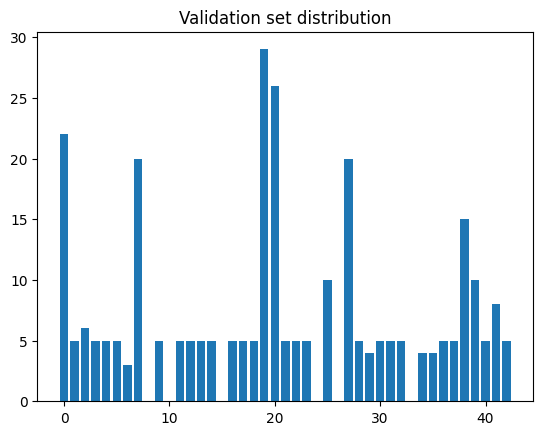

In [7]:
val_data = GroceryStoreDataset(split="val")
unique_val_classes, per_val_class_count = np.unique(val_data.labels, return_counts=True)
plt.title("Validation set distribution")
plt.bar(unique_val_classes, per_val_class_count)
plt.show()

## <a id='toc1_5_'></a>[Data preprocessing](#toc0_)

### <a id='toc1_5_1_'></a>[Dataset loading](#toc0_)

In [6]:
NUM_CLASSES = 43
INPUT_WIDTH = 348
INPUT_HEIGHT = 348

tsfms = T.Compose([
    T.ToTensor(),
    T.CenterCrop((INPUT_HEIGHT, INPUT_WIDTH)) # Some images are not the same size
])

train_dset = GroceryStoreDataset(split="train", transform=tsfms)
test_dset = GroceryStoreDataset(split="test", transform=tsfms)
val_dset = GroceryStoreDataset(split="val", transform=tsfms)

### <a id='toc1_5_2_'></a>[Augmentation](#toc0_)

In [ ]:
# Define the data augmentation transformations
USE_DATA_AUGMENTATION = False
AUGMENTATION_FACTOR = 2

augmentation_transforms = [T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomResizedCrop((INPUT_HEIGHT, INPUT_WIDTH), scale=(0.8, 1.0)),
    T.ToTensor(),
    T.CenterCrop((INPUT_HEIGHT, INPUT_WIDTH)) # Some images are not the same size
]), T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomResizedCrop((INPUT_HEIGHT, INPUT_WIDTH), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor(),
    T.CenterCrop((INPUT_HEIGHT, INPUT_WIDTH)) # Some images are not the same size
])]

# Check if thge file 'train_dset.pt' exists
if Path('train_dset.pt').exists():
    train_dset = torch.load('train_dset.pt')
else:
    # Concatenate the original and augmented training datasets
    if USE_DATA_AUGMENTATION:
        fix_random(SEED)
        print(f'Train dataset size before augmentation: {len(train_dset)}')
        for i in range(AUGMENTATION_FACTOR):
            for j in range(len(augmentation_transforms)):
                augmented_train_dset = GroceryStoreDataset(split="train", transform=augmentation_transforms[j])
                train_dset = ConcatDataset([train_dset, augmented_train_dset])
        print(f'Train dataset size after augmentation: {len(train_dset)}')
        # Dump the whole dataset for later use in order to avoid recomputing the augmentations
        torch.save(train_dset, 'train_dset.pt')

### <a id='toc1_5_3_'></a>[Rebalancing](#toc0_)

In [ ]:
REBALANCE_DATASET = False

class GroceryStoreDatasetFilteredByLabel(GroceryStoreDataset):
    def __init__(self, split: str, transform=None, label=None) -> None:
        super().__init__(split, transform)

        self.paths = [ p for i, p in enumerate(self.paths) if self.labels[i] == label ]
        self.labels = [label] * len(self.paths)

In [ ]:
if REBALANCE_DATASET:
    fix_random(SEED)
    balanced_train_dset = GroceryStoreDataset(split="train", transform=tsfms)
    balanced_count = [ balanced_train_dset.labels.count(i) for i in range(NUM_CLASSES) ]
    biggest_class_size = np.max(balanced_count)

    for i in range(NUM_CLASSES):
        size_label_i = train_dset.labels.count(i)
        increase_factor = round(biggest_class_size / size_label_i)

        for j in range(increase_factor-1):
            augmented_i = GroceryStoreDatasetFilteredByLabel(split="train", transform=augmentation_transforms[j % 2], label=i)
            balanced_train_dset = ConcatDataset([balanced_train_dset, augmented_i])
            balanced_count[i] += len(augmented_i)

    train_dset = balanced_train_dset

    plt.title("Rebalanced train set distribution")
    plt.bar(range(NUM_CLASSES), balanced_count)
    plt.show()

## <a id='toc1_6_'></a>[Utility functions](#toc0_)

### <a id='toc1_6_1_'></a>[Parameters count](#toc0_)

In [30]:
def getTotalParameters(ModelClass):
    model = ModelClass(NUM_CLASSES)
    total_params = 0

    for _, parameter in model.named_parameters():
        total_params += parameter.numel()

    return total_params

In [31]:
def print_model_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param_count = parameter.numel()
        total_params += param_count

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param_count = parameter.numel()
        print(f"Layer: {name:<30} | Parameters: {param_count:<8} ({param_count/total_params*100:.2f}%)")
        
    print(f"Total Trainable Parameters: {total_params}")

### <a id='toc1_6_2_'></a>[Evaluation on dataset split](#toc0_)

In [6]:
def evaluate(model, dataloader, device):
    corrects = 0
    total = 0
    model = model.to(device)

    with torch.no_grad():
        model.eval()
        for image, labels in dataloader:
            image, labels = image.to(device), labels.to(device)
            pred_logits = model(image)
            _, preds = torch.max(pred_logits, 1)
            corrects += (preds == labels).sum().item()
            total += labels.shape[0]

    return corrects / total

### <a id='toc1_6_3_'></a>[Training loop](#toc0_)

In [7]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    train_dl,
    val_dl,
    device,
    n_epochs,
    early_stop_val_acc = 0.6,
    checkpoint_path = None,
    logging_path = None
):
    if checkpoint_path is not None: os.makedirs(checkpoint_path, exist_ok=True)
    if logging_path is not None: os.makedirs(logging_path, exist_ok=True)

    history = []
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    for epoch in (pbar := tqdm(range(n_epochs))):
        batch_train_accuracies = []
        batch_train_losses = []
        batch_train_times = []
        val_accuracy = 0
        val_loss = 0
        curr_lr = scheduler.get_last_lr()[-1] if scheduler is not None else optimizer.param_groups[-1]['lr']

        # Train
        model.train()
        for i, (images, labels) in enumerate(train_dl):
            pbar.set_description(f"Epoch {epoch+1} ({i+1}/{len(train_dl)}) [lr: {curr_lr:.3e}]")
            if device == "cuda":
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
            images, labels = images.to(device), labels.to(device)

            if device == "cuda": start_time.record()
            optimizer.zero_grad()
            pred_logits = model(images)
            loss = loss_fn(pred_logits, labels)
            loss.backward()
            optimizer.step()
            if device == "cuda": end_time.record()

            _, preds = torch.max(pred_logits, 1)
            batch_train_accuracies.append((preds == labels).sum().item() / labels.size(0))
            batch_train_losses.append(loss.item())
            if device == "cuda":
                torch.cuda.synchronize()
                batch_train_times.append(start_time.elapsed_time(end_time))
        if scheduler is not None:
            scheduler.step()

        # Validation
        model.eval()
        val_accuracy_per_label_count = np.zeros((NUM_CLASSES, 2))
        with torch.no_grad():
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                preds_logits = model(images)
                _, pred = torch.max(preds_logits, 1)
                val_accuracy += (pred == labels).sum().item()
                for class_idx in range(NUM_CLASSES):
                    val_accuracy_per_label_count[class_idx,0] += np.logical_and((pred == labels).cpu().numpy(), (labels == class_idx).cpu().numpy()).sum()
                    val_accuracy_per_label_count[class_idx,1] += (labels == class_idx).sum().item()
                
                val_loss += loss_fn(preds_logits, labels).item() * labels.shape[0]
                
        val_accuracy = val_accuracy / len(val_dl.dataset)
        val_accuracy_per_label_count[val_accuracy_per_label_count[:,1] == 0, 1] = np.inf
        val_accuracy_per_label = val_accuracy_per_label_count[:,0] / val_accuracy_per_label_count[:,1]
        val_loss = val_loss / len(val_dl.dataset)

        print(
            f"Epoch {epoch + 1:<3} [lr: {curr_lr:.3e}] | "
            f"train_acc: {np.mean(batch_train_accuracies):.4f} "
            f"train_loss: {np.mean(batch_train_losses):.4f} "
            f"val_acc: {val_accuracy:.4f} "
            f"val_loss: {val_loss:.4f}",
        )

        # Checkpoint
        if checkpoint_path is not None:
            torch.save({
                "state_dict": model.state_dict(),
                "architecture": str(model)
            }, os.path.join(checkpoint_path, f"epoch{epoch+1}.ckp.pt"))

        # Logging
        epoch_logs = {
            "epoch": epoch + 1,
            "batch_train_accuracies": batch_train_accuracies,
            "batch_train_losses": batch_train_losses,
            "batch_train_times": batch_train_times,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss,
            "val_accuracy_per_label": val_accuracy_per_label.tolist()
        }
        if logging_path is not None:
            with open(os.path.join(logging_path, f"epoch{epoch+1}.log.json"), "w") as f:
                json.dump(epoch_logs, f, indent=3)
        history.append(epoch_logs)

        if (early_stop_val_acc is not None) and (val_accuracy >= early_stop_val_acc):
            break

    return history


In [8]:
def runForMultipleSeeds(ModelClass, num_runs, Loss, loss_args, Optimizer, optimizer_args, Scheduler, scheduler_args, batch_size, epochs, early_stop, device, random_seed, ckp_label=""):
    rng = np.random.default_rng(random_seed)
    runs_history = [None] * num_runs
    
    for i in range(num_runs):
        curr_seed = int(rng.integers(0, 2**32-1))
        fix_random(curr_seed)
        print(f"Running with seed: {curr_seed}")
        
        model = ModelClass(NUM_CLASSES).to(device)
        loss = Loss(**loss_args)
        optimizer = Optimizer(model.parameters(), **optimizer_args)
        scheduler = None
        if Scheduler is not None:
            scheduler = Scheduler(optimizer, **scheduler_args)
        train_dl = DataLoader(train_dset, batch_size, shuffle=True)

        runs_history[i] = train(
            model = model,
            loss_fn = loss,
            optimizer = optimizer,
            scheduler = scheduler,
            train_dl = train_dl,
            val_dl = DataLoader(val_dset, 256),
            device = device,
            n_epochs = epochs,
            early_stop_val_acc = early_stop,
            checkpoint_path = f"./checkpoints{i}_{ModelClass.__name__}_{ckp_label}",
            logging_path = f"./logs{i}_{ModelClass.__name__}_{ckp_label}"
        )
        
    return runs_history

### <a id='toc1_6_4_'></a>[Plots](#toc0_)

In [9]:
def plotLossAndAccuracy(histories, title):
    colors = "rgb"

    plt.figure(figsize=(16, 4))
    plt.suptitle(title)
    for i in range(len(histories)):
        logs = histories[i]
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(range(logs[-1]["epoch"]), [np.mean(logs[i]["batch_train_losses"]) for i in range(len(logs))], label=f"Train run {i}", color=colors[i%len(colors)])
        plt.plot(range(logs[-1]["epoch"]), [logs[i]["val_loss"] for i in range(len(logs))], "--", label=f"Val run {i}", color=colors[i%len(colors)])
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(range(logs[-1]["epoch"]), [np.mean(logs[i]["batch_train_accuracies"]) for i in range(len(logs))], label=f"Train run {i}", color=colors[i%len(colors)])
        plt.plot(range(logs[-1]["epoch"]), [logs[i]["val_accuracy"] for i in range(len(logs))], "--", label=f"Val run {i}", color=colors[i%len(colors)])
        plt.legend()
    plt.show()

In [10]:
def plotValPredictionDistribution(histories, title):
    colors = "rgb"
    
    plt.figure(figsize=(16, 7))
    plt.suptitle(f"Validation set correct predictions (%) and real distribution - {title}")
    for i in range(len(histories)):
        plt.subplot(len(histories)+1, 1, i+1)
        best_val_acc_idx = np.argmax([ histories[i][j]["val_accuracy"] for j in range(len(histories[i])) ])
        acc_per_label = histories[i][best_val_acc_idx]["val_accuracy_per_label"]
        plt.bar(range(len(acc_per_label)), acc_per_label, facecolor=colors[i%len(colors)], alpha=0.3, edgecolor="black", linewidth=2, label=f"run {i}")
        plt.legend()
    plt.subplot(len(histories)+1, 1, len(histories)+1)
    unique_val_classes, per_val_class_count = np.unique(val_dset.labels, return_counts=True)
    plt.bar(unique_val_classes, per_val_class_count, label="Val set distribution")
    plt.legend()
    plt.show()

### <a id='toc1_6_5_'></a>[Reporting](#toc0_)

In [11]:
def analyzeRunsHistory(ModelClass, label, histories):
    runs_val_acc = []
    runs_train_acc = []

    for num_run in range(len(histories)):
        best_val_acc_idx = np.argmax([ histories[num_run][i]["val_accuracy"] for i in range(len(histories[num_run])) ])
        best_train_acc = np.mean(histories[num_run][best_val_acc_idx]["batch_train_accuracies"])
        runs_val_acc.append(histories[num_run][best_val_acc_idx]["val_accuracy"])
        runs_train_acc.append(best_train_acc)

    return {
        "model": ModelClass.__name__,
        "label": label,
        "parameters": getTotalParameters(ModelClass),
        "avg_val_accuracy": np.mean(runs_val_acc),
        "min_val_accuracy": np.min(runs_val_acc),
        "max_val_accuracy": np.max(runs_val_acc),
        "avg_train_accuracy": np.mean(runs_train_acc),
        "num_runs": len(histories)
    }

In [12]:
def loadLogs(dir_path):
    run_dirs = [ f.path for f in os.scandir(dir_path) if f.is_dir() ]
    histories = [[] for _ in range(len(run_dirs))]

    for i, run_dir in enumerate(run_dirs):
        history_json_paths = next(os.walk(run_dir))[2]

        for json_path in history_json_paths:
            with open(os.path.join(run_dir, json_path), "r") as f:
                history_json = json.load(f)
                histories[i].append(history_json)
    for i in range(len(histories)):
        histories[i].sort(key=lambda x: x["epoch"])

    return histories

## <a id='toc1_7_'></a>[Part 1](#toc0_)
---

### <a id='toc1_7_1_'></a>[Basic Model](#toc0_)

Each Convolutional block in the network has the following structure:
1. 2D Convolution
2. SiLU Activation Function
3. Max Pooling
4. Batch Normalization
5. Dropout

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, kernel_size, in_channels, out_channels, activation, use_batch_norm=True, use_skip=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation()
        self.use_skip = use_skip

        block_components = [
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = kernel_size,
                stride = 2,
                padding = "valid"
            ),
            nn.BatchNorm2d(out_channels) if use_batch_norm else None,
            self.activation,
            nn.Conv2d(
                in_channels = out_channels,
                out_channels = out_channels,
                kernel_size = kernel_size,
                stride = 1,
                padding = "same"
            ),
            nn.BatchNorm2d(out_channels) if use_batch_norm else None,
            # self.activation,
            # nn.Conv2d(
            #     in_channels = out_channels,
            #     out_channels = out_channels,
            #     kernel_size = kernel_size,
            #     stride = 1,
            #     padding = "same"
            # ),
            # nn.BatchNorm2d(out_channels),
        ]
        self.block = nn.Sequential(*[ b for b in block_components if b is not None ])
        
        if use_skip:
            self.skip_block = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding="valid")

    def forward(self, x):
        out = self.block(x)
        # Residual connection
        if self.use_skip:
            residual = self.skip_block(x)
            out = out + residual
        return self.activation(out)


### <a id='toc1_7_2_'></a>[First Model](#toc0_)

In [18]:
class GroceryModelModular(nn.Module):
    def __init__(self, stem_block, conv_block, linear_block):
        super().__init__()
        self.stem_block = nn.Sequential(*stem_block)
        self.conv_block = nn.Sequential(*conv_block)
        self.linear_block = nn.Sequential(*linear_block)

    def forward(self, x):
        x = self.stem_block(x)
        x = self.conv_block(x)
        # Before flattening the tensor, to further reduce the parameters
        # we use adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.linear_block(x)
        return x

In [19]:
class GroceryModelFull(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [16]:
model = GroceryModelFull(NUM_CLASSES).to(device)
print_model_parameters(model)
print()
summary(model, (3 , INPUT_HEIGHT, INPUT_WIDTH), device=device.type)

Layer: stem_block.0.weight            | Parameters: 1800     (0.86%)
Layer: stem_block.0.bias              | Parameters: 24       (0.01%)
Layer: stem_block.1.weight            | Parameters: 24       (0.01%)
Layer: stem_block.1.bias              | Parameters: 24       (0.01%)
Layer: stem_block.3.weight            | Parameters: 19200    (9.16%)
Layer: stem_block.3.bias              | Parameters: 32       (0.02%)
Layer: stem_block.4.weight            | Parameters: 32       (0.02%)
Layer: stem_block.4.bias              | Parameters: 32       (0.02%)
Layer: conv_block.0.block.0.weight    | Parameters: 13824    (6.60%)
Layer: conv_block.0.block.0.bias      | Parameters: 48       (0.02%)
Layer: conv_block.0.block.1.weight    | Parameters: 48       (0.02%)
Layer: conv_block.0.block.1.bias      | Parameters: 48       (0.02%)
Layer: conv_block.0.block.3.weight    | Parameters: 20736    (9.90%)
Layer: conv_block.0.block.3.bias      | Parameters: 48       (0.02%)
Layer: conv_block.0.block.4.weight

In [18]:
default_args = {
    "ModelClass": GroceryModelFull, 
    "num_runs": 3,
    "Loss": nn.CrossEntropyLoss, 
    "loss_args": {}, 
    "Optimizer": optim.Adam, 
    "optimizer_args": { "lr": 1e-4, "weight_decay": 0.1 }, 
    "Scheduler": None,
    "scheduler_args": {},
    # Scheduler = optim.lr_scheduler.LinearLR, 
    # scheduler_args = { "start_factor": 1, "end_factor": 1/8, "total_iters": 25 }, 
    "batch_size": 64, 
    "epochs": 50,
    "early_stop": None,
    "device": device,
    "random_seed": SEED
}

histories_full = runForMultipleSeeds(**default_args)

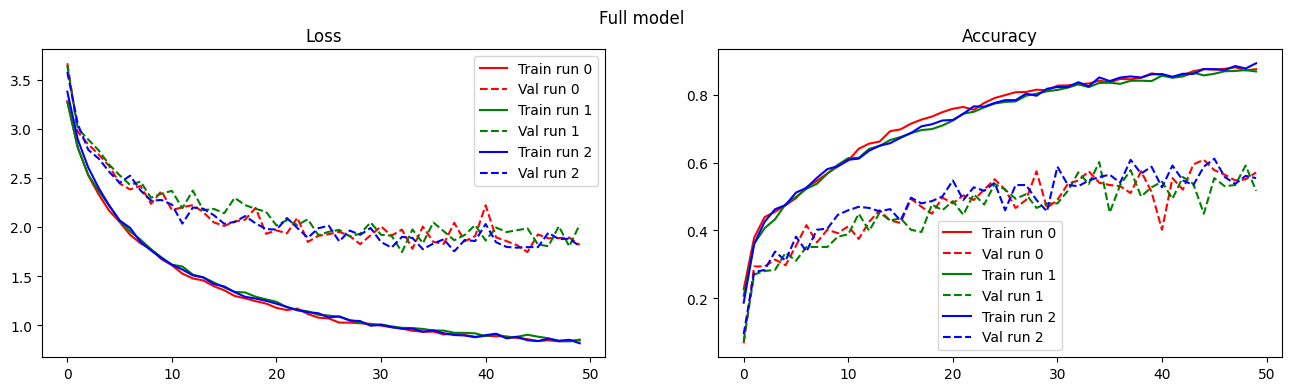

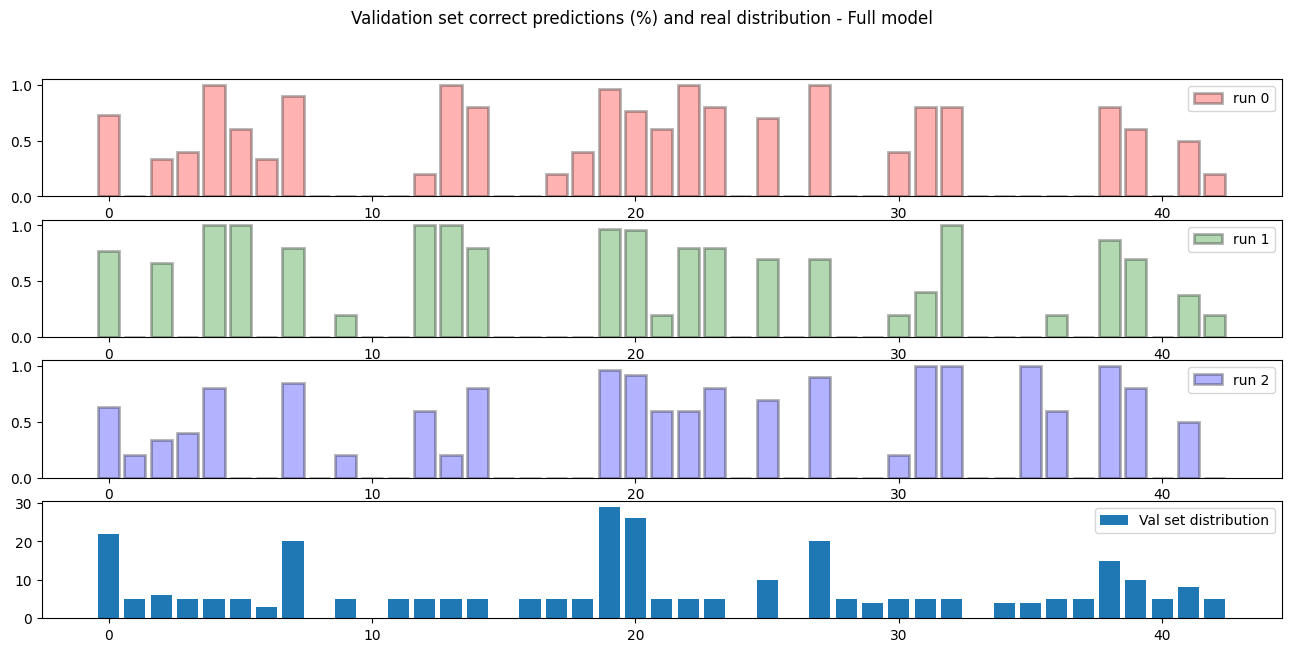

In [65]:
plotLossAndAccuracy(histories_full, "Full model")
plotValPredictionDistribution(histories_full, "Full model")

From the plots above, we can observe that:
- Loss and accuracy on the validation set show a slightly unstable behavior.
- Due to the unbalanced classes of the dataset, the model is biased towards the labels with a bigger number of training examples.

### <a id='toc1_7_3_'></a>[Ablation study](#toc0_)

To test the effectiveness of each component of the proposed architecture, we perform an ablation study in which we partially remove components of the network and test the resulting performance.

We perform the following experiments on the model architecture:
- A smaller stem layer.
- No stem layer at all.
- A smaller convolution block.
- A smaller number of channels.
- A smaller fully-connected layer.
- No batch normalization.
- No dropout.
- No skip connections.

Furthermore, we perform the following experiments on the hyperparameters:
- No weight decay.
- A higher learning rate.
- A smaller batch size.
- A larger batch size.

#### <a id='toc1_7_3_1_'></a>[Models definition](#toc0_)

In [20]:
class GroceryModelSmallStem(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [21]:
class GroceryModelNoStem(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=3, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [22]:
class GroceryModelSmallConvBlock(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(48, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [23]:
class GroceryModelSmaller(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(16),
                nn.SiLU(),
                nn.Conv2d(in_channels=16, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=24, out_channels=32, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(48, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [24]:
class GroceryModelSmallLinear(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 128),
                nn.BatchNorm1d(128),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(128, n_classes)
            ]
        )

In [25]:
class GroceryModelNoBatchNorm(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU, use_batch_norm=False),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU, use_batch_norm=False)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [26]:
class GroceryModelNoDropout(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Linear(256, n_classes)
            ]
        )

In [27]:
class GroceryModelNoSkip(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU, use_skip=False),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU, use_skip=False)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Linear(256, n_classes)
            ]
        )

#### <a id='toc1_7_3_2_'></a>[Tests execution](#toc0_)

In [ ]:
to_test_models = [
    GroceryModelSmallStem, 
    GroceryModelSmallConvBlock, 
    GroceryModelNoStem, 
    GroceryModelSmaller, 
    GroceryModelSmallLinear, 
    GroceryModelNoBatchNorm, 
    GroceryModelNoDropout,
    GroceryModelNoSkip
]

stats_arch_ablation = []

for Model in to_test_models:
    print(f"Running {Model.__name__}")

    args = copy.deepcopy(default_args)
    args["ModelClass"] = Model
    histories = runForMultipleSeeds(**args)
    
    stats_arch_ablation.append( analyzeRunsHistory(Model, "",  histories) )
    plotLossAndAccuracy(histories, Model.__name__)
    plotValPredictionDistribution(histories, Model.__name__)

In [ ]:
histories_hyper_study = []
stats_hyper_study = []

args = copy.deepcopy(default_args)
args["optimizer_args"] = { "lr": 1e-4 }
histories_hyper_study.append( runForMultipleSeeds(**args, ckp_label="no_wd") )
stats_hyper_study.append( analyzeRunsHistory(GroceryModelFull, "no weight decay", histories_hyper_study[-1]) )
plotLossAndAccuracy(histories_hyper_study[-1], "Full model + no weight decay")
plotValPredictionDistribution(histories_hyper_study[-1], "Full model + no weight decay")

args = copy.deepcopy(default_args)
args["optimizer_args"] = { "lr": 5e-4, "weight_decay": 0.1 }
histories_hyper_study.append( runForMultipleSeeds(**args, ckp_label="high_lr") )
stats_hyper_study.append( analyzeRunsHistory(GroceryModelFull, "higher LR", histories_hyper_study[-1]) )
plotLossAndAccuracy(histories_hyper_study[-1], "Full model + higher LR")
plotValPredictionDistribution(histories_hyper_study[-1], "Full model + higher LR")

args = copy.deepcopy(default_args)
args["batch_size"] = 32
histories_hyper_study.append( runForMultipleSeeds(**args, ckp_label="small_bs") )
stats_hyper_study.append( analyzeRunsHistory(GroceryModelFull, "smaller batch size", histories_hyper_study[-1]) )
plotLossAndAccuracy(histories_hyper_study[-1], "Full model + smaller batch size")
plotValPredictionDistribution(histories_hyper_study[-1], "Full model + smaller batch size")

args = copy.deepcopy(default_args)
args["batch_size"] = 128
histories_hyper_study.append( runForMultipleSeeds(**args, ckp_label="large_bs") )
stats_hyper_study.append( analyzeRunsHistory(GroceryModelFull, "larger batch size", histories_hyper_study[-1]) )
plotLossAndAccuracy(histories_hyper_study[-1], "Full model + larger batch size")
plotValPredictionDistribution(histories_hyper_study[-1], "Full model + larger batch size")

#### <a id='toc1_7_3_3_'></a>[Results](#toc0_)

In [28]:
histories_full = loadLogs("./train-logs/GroceryModelFull")
histories_small_stem = loadLogs("./train-logs/GroceryModelSmallStem")
histories_small_conv_block = loadLogs("./train-logs/GroceryModelSmallConvBlock")
histories_no_stem = loadLogs("./train-logs/GroceryModelNoStem")
histories_smaller = loadLogs("./train-logs/GroceryModelSmaller")
histories_small_linear = loadLogs("./train-logs/GroceryModelSmallLinear")
histories_no_batch_norm = loadLogs("./train-logs/GroceryModelNoBatchNorm")
histories_no_dropout = loadLogs("./train-logs/GroceryModelNoDropout")
histories_no_skip = loadLogs("./train-logs/GroceryModelNoSkip")
histories_full_no_wd = loadLogs("./train-logs/GroceryModelFull_no_wd")
histories_full_high_lr = loadLogs("./train-logs/GroceryModelFull_high_lr")
histories_full_small_bs = loadLogs("./train-logs/GroceryModelFull_small_bs")
histories_full_large_bs = loadLogs("./train-logs/GroceryModelFull_large_bs")

In [29]:
all_stats = [
    analyzeRunsHistory(GroceryModelFull, "", histories_full),
    analyzeRunsHistory(GroceryModelSmallStem, "", histories_small_stem),
    analyzeRunsHistory(GroceryModelSmallConvBlock, "", histories_small_conv_block),
    analyzeRunsHistory(GroceryModelNoStem, "", histories_no_stem),
    analyzeRunsHistory(GroceryModelSmaller, "", histories_smaller),
    analyzeRunsHistory(GroceryModelSmallLinear, "", histories_small_linear),
    analyzeRunsHistory(GroceryModelNoBatchNorm, "", histories_no_batch_norm),
    analyzeRunsHistory(GroceryModelNoDropout, "", histories_no_dropout),
    analyzeRunsHistory(GroceryModelNoSkip, "", histories_no_skip),
    analyzeRunsHistory(GroceryModelFull, "No weight decay", histories_full_no_wd),
    analyzeRunsHistory(GroceryModelFull, "Higher LR", histories_full_high_lr),
    analyzeRunsHistory(GroceryModelFull, "Smaller batch size", histories_full_small_bs),
    analyzeRunsHistory(GroceryModelFull, "Larger batch size", histories_full_large_bs)
]

display(pd.DataFrame.from_dict(all_stats))

NameError: name 'getTotalParameters' is not defined

From the results shown in the table above, the following relevant observations can be made:
- Batch normalization has a crucial role for the model as without it during training performance remains very low.
- Dropout has little impact in the overall results. Still, as it is computationally inexpensive, we kept it in the final model. Also keeping it also allows to consistently reach the target $0.6$ accuracy over different initialization seeds.
- Reducing the number of layers or channels (rows 1 to 5 in the table) all worsen the results disallowing to reach the target accuracy.
- Without weight decay, we can observe that the model overfits quickly (as it can be seen in the train accuracy). Nevertheless, it is able to reach the target validation accuracy.
- Ultimately, we observed that a smaller batch size have slightly better accuracy. We hypothesize that this is due to the fact that a smaller batch size has a better generalization capability. On the other side, a larger batch generalizes less as it shows a higher gap between train accuracy and validation accuracy compared to using a smaller batch.

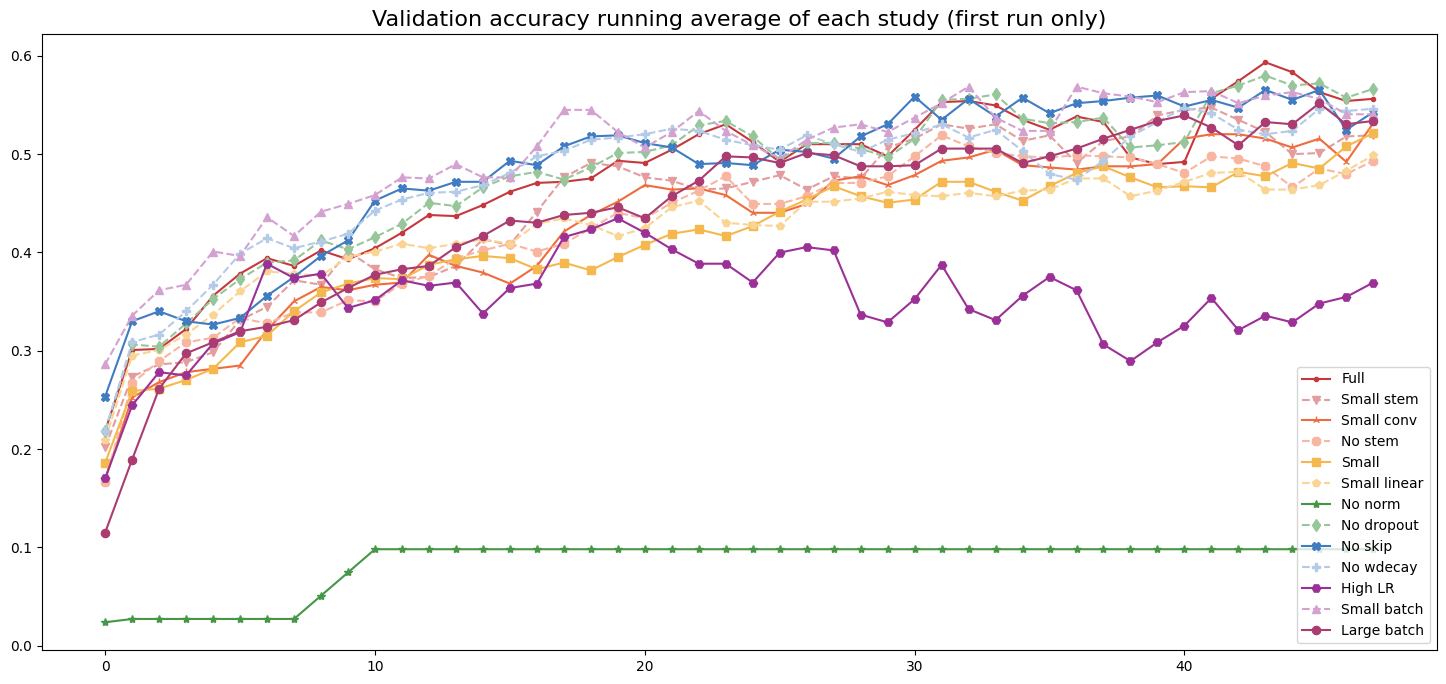

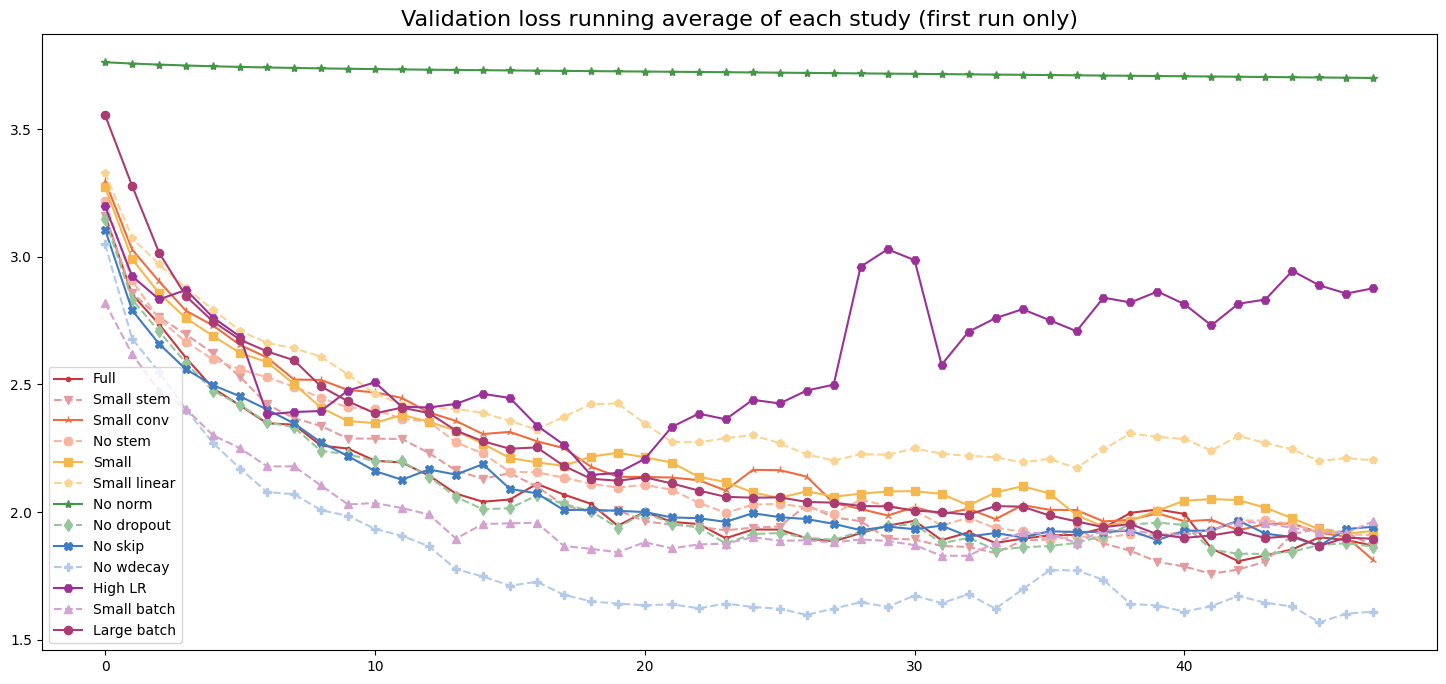

In [35]:
plot_histories = [
    (histories_full, "Full", ".", "#c6383d"), 
    (histories_small_stem, "Small stem", "v", "#e39d9f"), 
    (histories_small_conv_block, "Small conv", "2", "#ef6c3f"), 
    (histories_no_stem, "No stem", "8", "#f8b6a0"), 
    (histories_smaller, "Small", "s", "#f5b84e"), 
    (histories_small_linear, "Small linear", "p", "#fad492"), 
    (histories_no_batch_norm, "No norm", "*", "#459647"), 
    (histories_no_dropout, "No dropout", "d", "#97c69a"), 
    (histories_no_skip, "No skip", "X", "#407cc2"), 
    (histories_full_no_wd, "No wdecay", "P", "#b4cbe8"), 
    (histories_full_high_lr, "High LR", "H", "#9b3197"), 
    (histories_full_small_bs, "Small batch", "^", "#d3a2d1"), 
    (histories_full_large_bs, "Large batch", (12, 0, 0), "#ab3c72")
]

plt.figure(figsize=(18, 8))
plt.title("Validation accuracy running average of each study (first run only)", fontsize=16)
for i, (hist, label, marker, color) in enumerate(plot_histories):
    line_style = "-" if i % 2 == 0 else "--"
    running_avg_accuracy = np.convolve([ hist[0][e]["val_accuracy"] for e in range(len(hist[0])) ], np.ones(3)/3, mode="valid")
    plt.plot(range(len(running_avg_accuracy)), running_avg_accuracy, line_style, label=label, marker=marker, color=color)
plt.legend()
plt.show()

plt.figure(figsize=(18, 8))
plt.title("Validation loss running average of each study (first run only)", fontsize=16)
for i, (hist, label, marker, color) in enumerate(plot_histories):
    line_style = "-" if i % 2 == 0 else "--"
    running_avg_loss = np.convolve([ hist[0][e]["val_loss"] for e in range(len(hist[0])) ], np.ones(3)/3, mode="valid")
    plt.plot(range(len(running_avg_loss)), running_avg_loss, line_style, label=label, marker=marker, color=color)
plt.legend()
plt.show()

### <a id='toc1_7_4_'></a>[Experiment on balanced dataset](#toc0_)

## <a id='toc1_8_'></a>[Part 2](#toc0_)
---

In [31]:
class GroceryModelResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        self.freezeAll()
        self.unfreezeLinear()
    

    def freezeAll(self):
        for p in self.resnet.parameters():
            p.requires_grad = False

    def unfreezeAll(self):
        for p in self.resnet.parameters():
            p.requires_grad = True
        
    def freezeLinear(self):
        for p in self.resnet.fc.parameters():
            p.requires_grad = False

    def unfreezeLinear(self):
        for p in self.resnet.fc.parameters():
            p.requires_grad = True


    def forward(self, x):
        return self.resnet(x)

In [32]:
model = GroceryModelResNet(NUM_CLASSES)
print_model_parameters(model)
summary(model, (3, 10, 10), device="cpu")

Layer: resnet.fc.weight               | Parameters: 22016    (99.81%)
Layer: resnet.fc.bias                 | Parameters: 43       (0.19%)
Total Trainable Parameters: 22059
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 5, 5]           9,408
       BatchNorm2d-2             [-1, 64, 5, 5]             128
              ReLU-3             [-1, 64, 5, 5]               0
         MaxPool2d-4             [-1, 64, 3, 3]               0
            Conv2d-5             [-1, 64, 3, 3]          36,864
       BatchNorm2d-6             [-1, 64, 3, 3]             128
              ReLU-7             [-1, 64, 3, 3]               0
            Conv2d-8             [-1, 64, 3, 3]          36,864
       BatchNorm2d-9             [-1, 64, 3, 3]             128
             ReLU-10             [-1, 64, 3, 3]               0
       BasicBlock-11             [-1, 64, 3, 3]           

In [34]:
fix_random(SEED)

model = GroceryModelResNet(NUM_CLASSES).to(device)
loss = default_args["Loss"](**default_args["loss_args"])
optimizer = default_args["Optimizer"](model.parameters(), **default_args["optimizer_args"])
scheduler = None
if default_args["Scheduler"] is not None:
    scheduler = default_args["Scheduler"](optimizer, **default_args["scheduler_args"])

history_resnet = train(
    model = model,
    loss_fn = loss,
    optimizer = optimizer,
    scheduler = scheduler,
    train_dl = DataLoader(train_dset, 32, shuffle=True),
    val_dl = DataLoader(val_dset, 256),
    device = device,
    n_epochs = default_args["epochs"],
    early_stop_val_acc = 0.85,
    checkpoint_path = f"./checkpoints_{GroceryModelResNet.__name__}",
    logging_path = f"./logs_{GroceryModelResNet.__name__}"
)
        

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1   [lr: 1.000e-04] | train_acc: 0.1663 train_loss: 3.3110 val_acc: 0.1791 val_loss: 3.2365
Epoch 2   [lr: 1.000e-04] | train_acc: 0.2355 train_loss: 2.9989 val_acc: 0.2432 val_loss: 3.0691
Epoch 3   [lr: 1.000e-04] | train_acc: 0.3017 train_loss: 2.8112 val_acc: 0.2905 val_loss: 2.9141
Epoch 4   [lr: 1.000e-04] | train_acc: 0.3385 train_loss: 2.6409 val_acc: 0.2973 val_loss: 2.7781
Epoch 5   [lr: 1.000e-04] | train_acc: 0.4036 train_loss: 2.4815 val_acc: 0.3243 val_loss: 2.6523
Epoch 6   [lr: 1.000e-04] | train_acc: 0.4379 train_loss: 2.3404 val_acc: 0.3547 val_loss: 2.5465
Epoch 7   [lr: 1.000e-04] | train_acc: 0.4550 train_loss: 2.2244 val_acc: 0.3682 val_loss: 2.4452
Epoch 8   [lr: 1.000e-04] | train_acc: 0.5179 train_loss: 2.1123 val_acc: 0.4020 val_loss: 2.3522
Epoch 9   [lr: 1.000e-04] | train_acc: 0.5402 train_loss: 2.0125 val_acc: 0.4189 val_loss: 2.2792
Epoch 10  [lr: 1.000e-04] | train_acc: 0.5796 train_loss: 1.9099 val_acc: 0.4561 val_loss: 2.2069
Epoch 11  [lr: 1.000

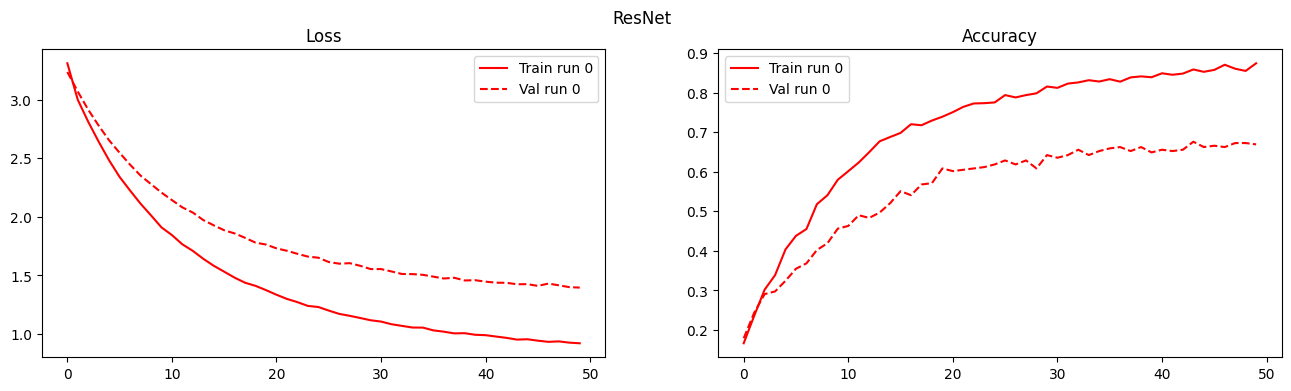

In [36]:
plotLossAndAccuracy([history_resnet], "ResNet")

In [ ]:
fix_random(SEED)
model.unfreezeAll()

history_resnet_finetune = train(
    model = model,
    loss_fn = loss,
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.1),
    scheduler = None,
    train_dl = DataLoader(train_dset, 32, shuffle=True),
    val_dl = DataLoader(val_dset, 256),
    device = device,
    n_epochs = 10,
    early_stop_val_acc = 0.85,
    checkpoint_path = f"./checkpoints_{GroceryModelResNet.__name__}_finetune",
    logging_path = f"./logs_{GroceryModelResNet.__name__}_finetune"
)